In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import os
import re
import seaborn as sns
import scipy.stats as ss
import random

In [2]:
pit_stops=pd.read_csv(r'./csv//pit_stops.csv')
races=pd.read_csv(r'./csv/races.csv')
drivers=pd.read_csv(r'./csv/drivers.csv')

In [3]:
pit_stops.drop(['time', 'duration'], axis=1, inplace=True)
# quitar hora de parada y tiempo en segundos

In [4]:
# cambiar tipo de campo milisegundpos a entero
pit_stops["milliseconds"].astype(int)

0       26898
1       25021
2       23426
3       23251
4       23842
        ...  
9891    22054
9892    22731
9893    21537
9894    22062
9895    22357
Name: milliseconds, Length: 9896, dtype: int32

In [5]:
print('Primera carrera registrada en csv pit_stops: Nº {}, {} {}'.format(pit_stops['raceId'].min(), races.loc[839, 'name'], races.loc[races[races.raceId==841].index[0], 'year']))
print('Última carrera registrada en csv pit_stops: {}, {} {}'.format(pit_stops['raceId'].max(), races.loc[1085, 'name'], races.loc[races[races.raceId==1105].index[0], 'year']))

Primera carrera registrada en csv pit_stops: Nº 841, Australian Grand Prix 2011
Última carrera registrada en csv pit_stops: 1105, Spanish Grand Prix 2023


In [6]:
# rango de los indices de las carreras válidas  == 839 a 1085 (para las carreras 841 a 1105)

races[(races.raceId>=841) & (races.raceId<=1105)].index

Index([ 839,  840,  841,  842,  843,  844,  845,  846,  847,  848,
       ...
       1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085],
      dtype='int64', length=247)

In [7]:
# a partir del índice de races, creo un diccionario con raceId y nombre (para generar gráficos personalizados)

dictraces={}
nombre_carreras=races[['raceId','name','year']]
for i in races[(races.raceId>=841) & (races.raceId<=1105)].index:
    dictraces[nombre_carreras.loc[i,'raceId']]={'año':nombre_carreras.loc[i, 'year'], 'nombre':nombre_carreras.loc[i, 'name'] }


# ejemplos de  acceso
print(dictraces[841]['año'])
print(dictraces[841]['nombre'])
print(dictraces[841])
print(dictraces[1105]['año'])
print(dictraces[1105]['nombre'])
print(dictraces[1105])

2011
Australian Grand Prix
{'año': 2011, 'nombre': 'Australian Grand Prix'}
2023
Spanish Grand Prix
{'año': 2023, 'nombre': 'Spanish Grand Prix'}


In [8]:
# a partir de drivers creo un diccionario con driverId (identificador de conductor y driverRef (alias) 
# se añadirá a pit_stops y despues al dataframe final

dictDrivers={}

for i in drivers.index:
    dictDrivers[drivers.loc[i,'driverId']]=drivers.loc[i,'driverRef']


# ejemplo de acceso
print('Número de conductores: {}'.format(len(dictDrivers)))
print('Conductor Id1 {}'.format(dictDrivers[1]))
print('Conductor Id4 {}'.format(dictDrivers[4]))

Número de conductores: 857
Conductor Id1 hamilton
Conductor Id4 alonso


In [9]:
# añadimos columna con alias de conductor al lado de su Id
 
pit_stops.insert(loc = 2,
          column = 'driver',
          value = pit_stops['driverId'].map(dictDrivers))

*columnas pit_stops*

- raceId: identificador de carrera
- driverId: identificador de conductor
- driver: alias conductor
- stop: número de parada (1,2,3..)
- lap: vuelta en la que hace la parada indicada en driver
- milliseconds: tiempo de boxes en milisegundos

In [10]:
pit_stops

,raceId,driverId,driver,stop,lap,milliseconds
0,841,153,alguersuari,1,1,26898
1,841,30,michael_schumacher,1,1,25021
2,841,17,webber,1,11,23426
3,841,4,alonso,1,12,23251
4,841,13,massa,1,13,23842
...,...,...,...,...,...,...
9891,1105,847,russell,2,45,22054
9892,1105,1,hamilton,2,50,22731
9893,1105,815,perez,2,50,21537
9894,1105,846,norris,3,50,22062


In [11]:
# pit_stops[(pit_stops.raceId==1105) & ((pit_stops.driverId==4)|(pit_stops.driverId==1))]

#elegir conductores y carrera concreta

In [12]:
# pit_stops.loc[9853:9855]

#elegir por indice concreto

### <span style="color:YELLOW">ESTUDIO DE TIEMPOS DE PIT-STOP</span>

░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░

> <font size="0.3"> LOS TIEMPOS DEL DATASET SON <span style="color:RED">***PITSTOP IN - PITSTOP OUT***</span>  
>>NO SÓLO EL TIEMPO DE TRABAJO DE MECÁNICOS</font>

### Como afecta la bandera roja  
<img src="img/banderaroja.jpg"  width="200" style="border:5px double white;">

https://www.dazn.com/es-ES/news/f%C3%B3rmula-1/que-significa-bandera-roja-formula-1/vp8qy830860r1wd1qiwpp6k14


En la F1 suele ser habitual esta bandera por un accidente o causas metereológicas.  
Significado: detención de los entrenamientos o de la carrera.  

Estas son sus particularidades:

- Todos los pilotos deben reducir inmediatamente su velocidad, detenerse si es necesario y <span style="color:RED">volver a los boxes</span>
- Está prohibido adelantar.
- Esta bandera se muestra únicamente por orden del director de carrera.
- Todos los semáforos del trazado se pondrán en rojo.
- Se podrá sacar bandera roja en cualquier momento sin importar la vuelta.  

*Esto afecta directamente a la comparación de tiempos si se comparan con el resto de carreras*

░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░

#### En estos dos gráficos, sobre todo en el primero, vemos que los tiempos en general de pitstops de todas las carreras, están claramente por debajo de los 75000ms

In [13]:
from plotnine import ggplot, aes, facet_grid, labs, geom_point, theme, element_text

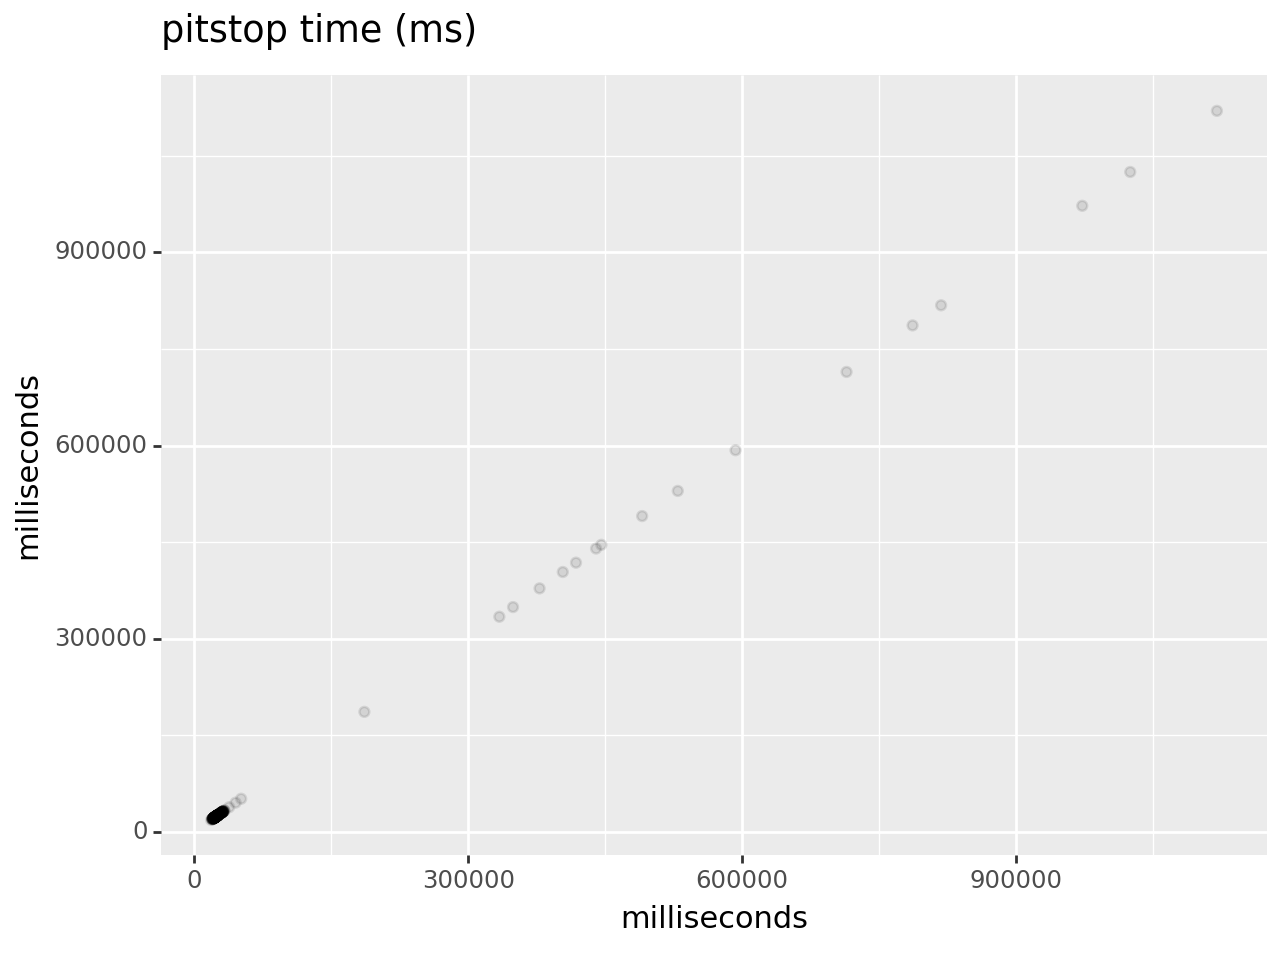

<Figure Size: (640 x 480)>

In [14]:
(
    ggplot(pit_stops[['raceId','milliseconds']].groupby('raceId').agg('mean'), aes(x='milliseconds', y='milliseconds'))
    + geom_point(alpha=0.1)
    + labs(
        x='milliseconds' 
        ,y='milliseconds'
        , title="pitstop time (ms)")
    
)

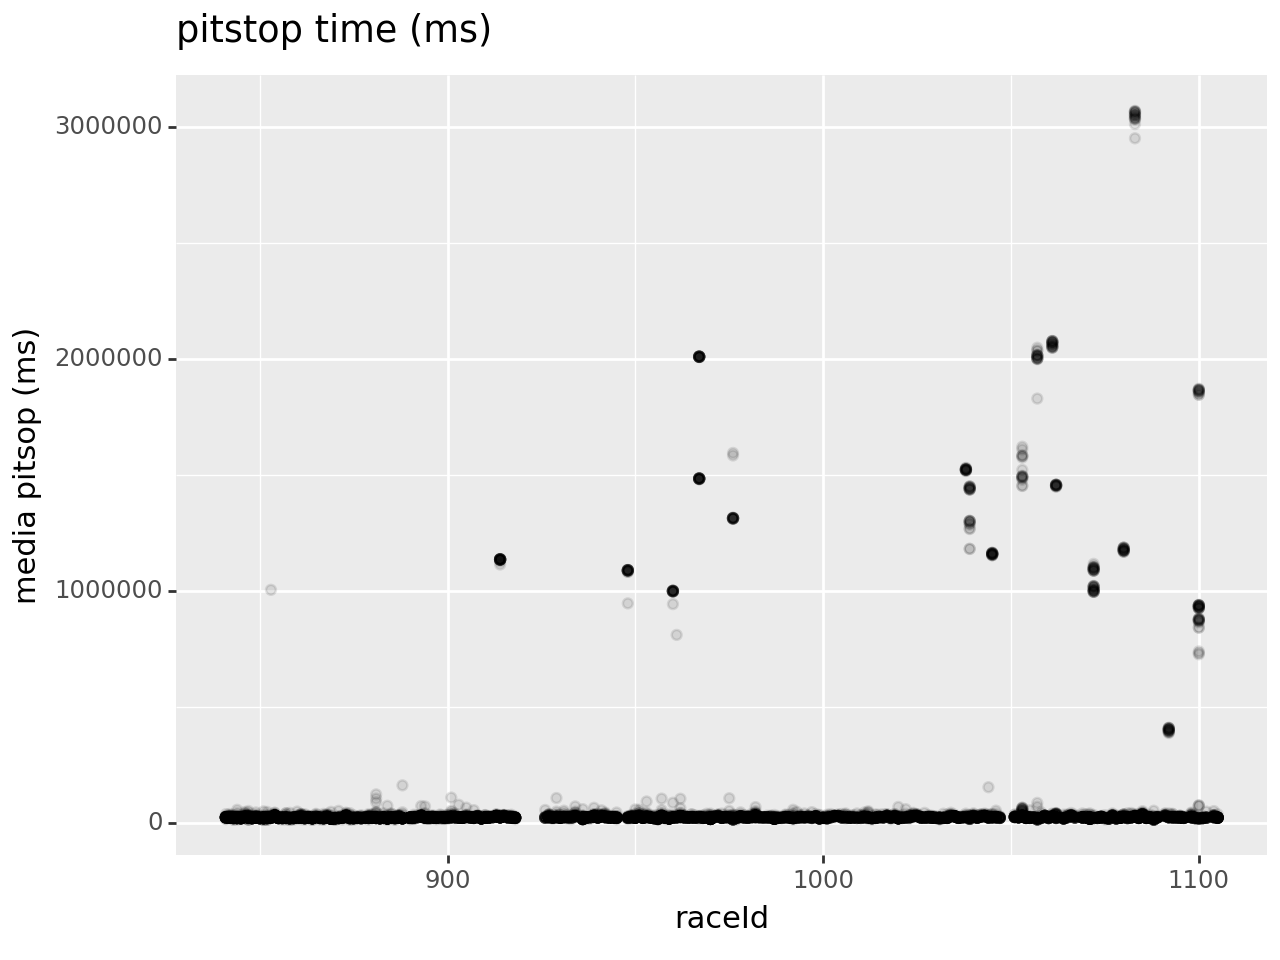

<Figure Size: (640 x 480)>

In [15]:
(
    #ggplot(pit_stops[['raceId','milliseconds']].groupby('raceId').agg('mean'), aes(x='milliseconds', y='milliseconds'))
    ggplot(pit_stops[['raceId','milliseconds']], aes(x='raceId', y='milliseconds'))
    + geom_point(alpha=0.1)
    + labs(
        x='raceId' 
        ,y='media pitsop (ms)'
        ,title="pitstop time (ms)"
        )
    
)

+ Revisión primer intevalo, paradas de 75000ms hay y en que carreras

In [16]:
pit_stops[pit_stops.milliseconds>75000].groupby('raceId').count().sort_values('driverId')

,driverId,driver,stop,lap,milliseconds
raceId,,,,,
853,1,1,1,1,1
1044,1,1,1,1,1
962,1,1,1,1,1
961,1,1,1,1,1
957,1,1,1,1,1
953,1,1,1,1,1
975,1,1,1,1,1
903,1,1,1,1,1
901,1,1,1,1,1


+ revisamos como ejemplos la carrera 1100 y la 1083

In [17]:
print(races['url'][races.raceId==1100])
print(races['url'][races.raceId==1083])

1081    https://en.wikipedia.org/wiki/2023_Australian_...
Name: url, dtype: object
1066    http://en.wikipedia.org/wiki/2022_British_Gran...
Name: url, dtype: object


* Wikipedia nos informa que el GP de Australia tuvo hasta tres banderas rojas  

[wikipedia GP Australia 2011](https://es.wikipedia.org/wiki/Anexo:Gran_Premio_de_Australia_de_2023)

* Y el gran PRemio de Gran bretaña 2022, tuvo un accidente multimple al empezar y durante la carreras unos pretestantes se sentaron en medio del circuito

[wikipedia GP Gran Bretaña 2022](https://es.wikipedia.org/wiki/Anexo:Gran_Premio_de_Gran_Breta%C3%B1a_de_2022)

In [18]:
# tiempos entre 75000 y 500.000ms
# (
#     ggplot(pit_stops[['raceId','milliseconds']][(pit_stops.milliseconds>75000)& (pit_stops.milliseconds<500000)].groupby('raceId').agg('mean'), aes(x='milliseconds', y='milliseconds'))
#     + geom_point(alpha=0.1)
#     + labs(
#         x='MILLISECONDS' 
#         ,y='MILLISECONDS'
#         ,title="pitstop tiempo medio >75000ms y <500000ms")
    
# )

In [19]:
# carreras con tiempos mayores a 2.000.000ms
# pit_stops[['raceId','milliseconds']][pit_stops.milliseconds>2000000].groupby('raceId').count()

* Desechados los tiempos mayores a 75000ms, estudiamos el intervalo inferior.  

    - Es consistente el tiempo entre los 15000 y los 35000 para todas las carreras

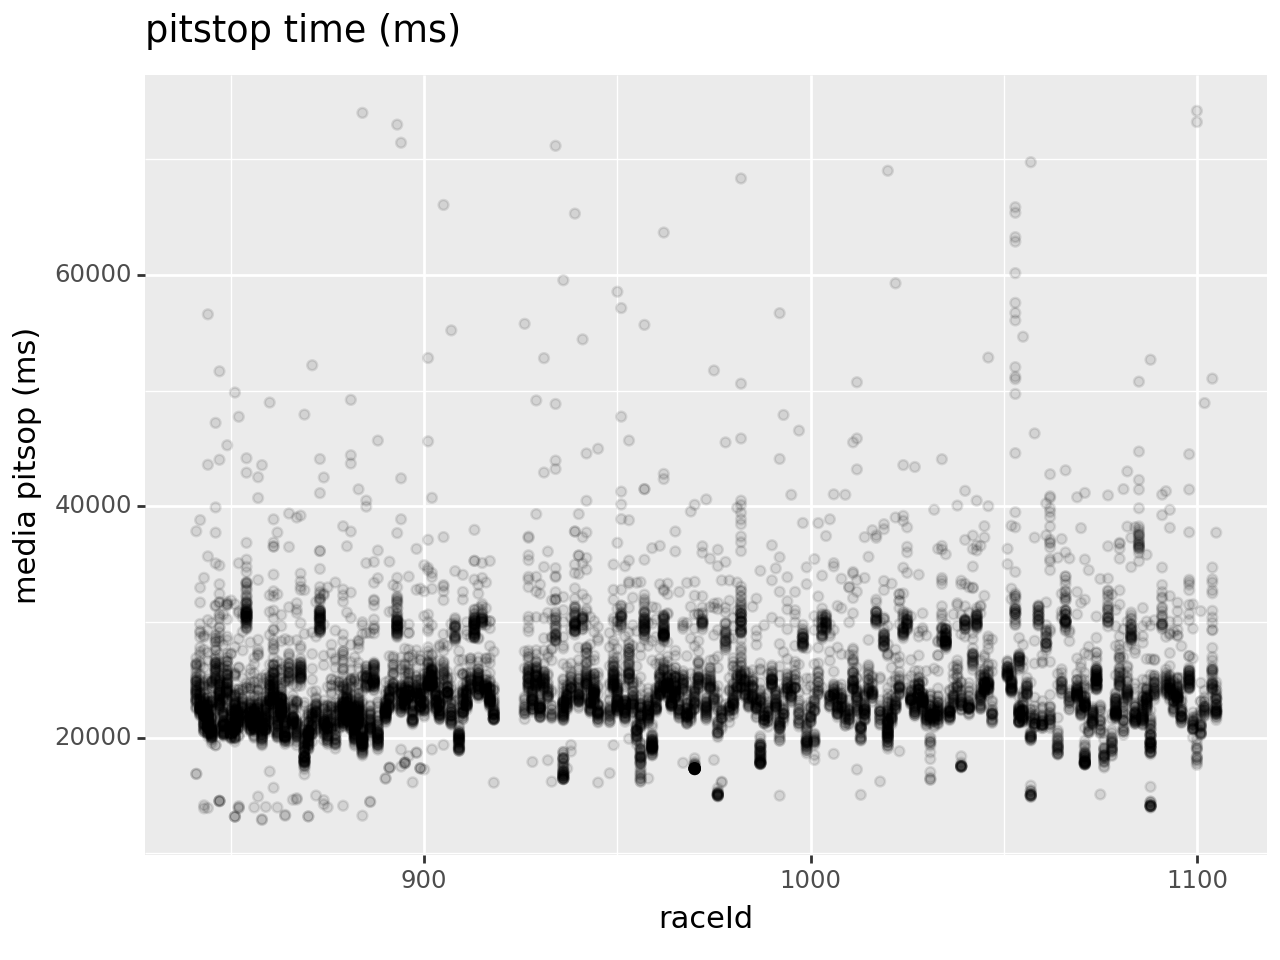

<Figure Size: (640 x 480)>

In [20]:
(
    ggplot(pit_stops[['raceId','milliseconds']][pit_stops.milliseconds<75000], aes(x='raceId', y='milliseconds'))
    + geom_point(alpha=0.1)
    + labs(
        x='raceId' 
        ,y='media pitsop (ms)'
        ,title="pitstop time (ms)"
        )
    
)

* casos hay entre 35000ms y 40000ms: 167
+ casos entre 35000ms y 75000ms: 296
+ casos superiores a 75000ms: 390


In [21]:
pit_stops['driverId'][((pit_stops.milliseconds>35000))&(pit_stops.milliseconds<40000)].count()

167

In [22]:
pit_stops['driverId'][((pit_stops.milliseconds>35000))&(pit_stops.milliseconds<75000)].count()

296

In [23]:
pit_stops['driverId'][pit_stops.milliseconds>75000].count()

390

* Deshechamos outliers por encima de 35000ms y nos quedamos con 9210 registros

In [24]:
pit_stops['driverId'][pit_stops.milliseconds<35000].count()

9210

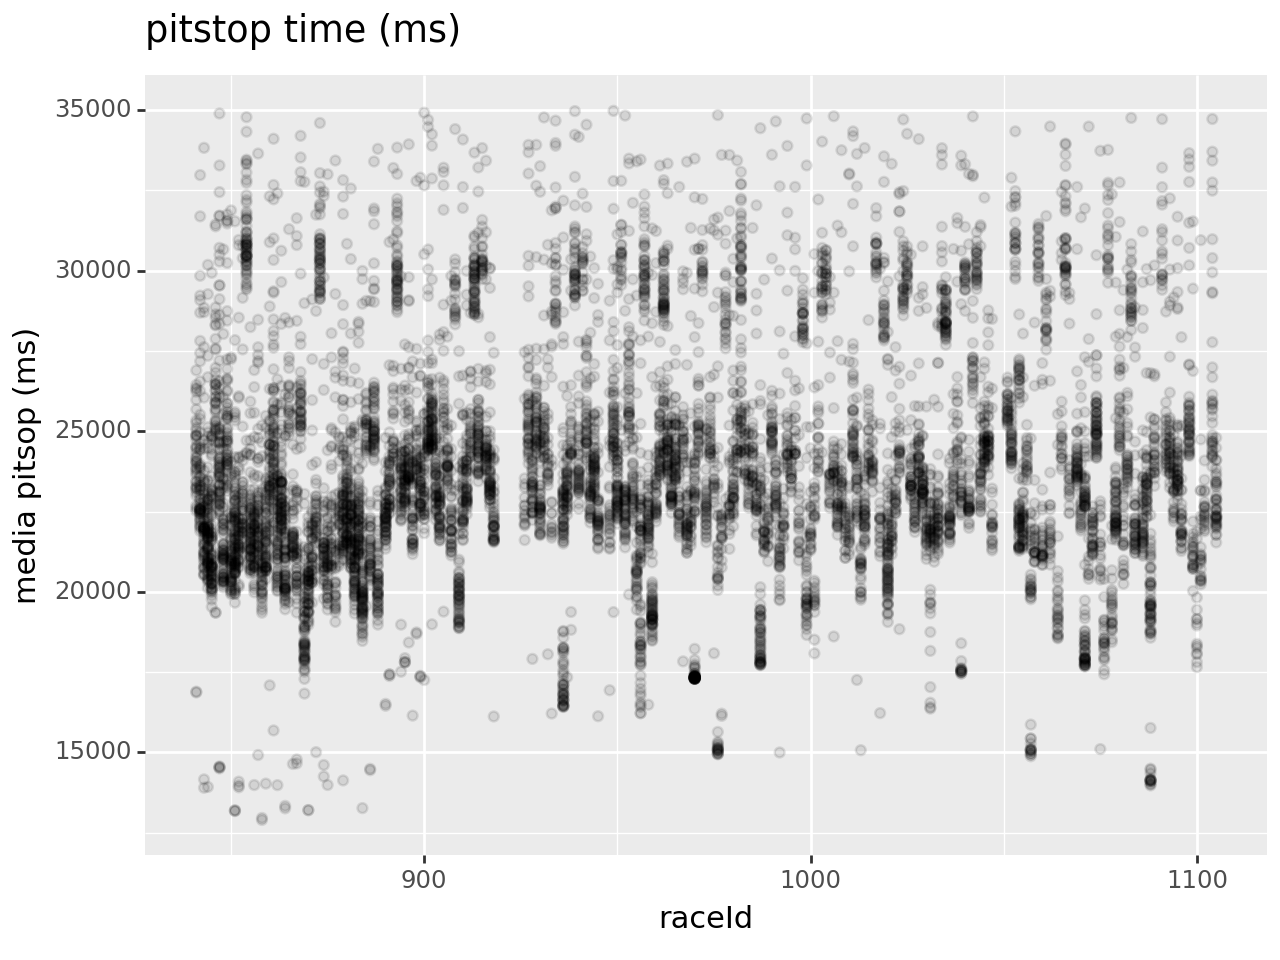

<Figure Size: (640 x 480)>

In [25]:
(
    #ggplot(pit_stops[['raceId','milliseconds']].groupby('raceId').agg('mean'), aes(x='milliseconds', y='milliseconds'))
    ggplot(pit_stops[['raceId','milliseconds']][(pit_stops.milliseconds<35000)], aes(x='raceId', y='milliseconds'))
    + geom_point(alpha=0.1)
    + labs(
        x='raceId' 
        ,y='media pitsop (ms)'
        ,title="pitstop time (ms)"
        )
    
)

In [26]:

# (
#     ggplot(pit_stops[['raceId','milliseconds']][pit_stops.milliseconds<35000].groupby('raceId').agg('mean'), aes(x='milliseconds', y='milliseconds'))
#     + geom_point(alpha=0.1)
#     + labs(
#         x='miliseconds' 
#         ,y='miliseconds'
#         , title="pitstop MEANTIME < 75000ms")
    
# )

In [27]:
# (
#        # ggplot(pit_stops[(pit_stops.raceId==1105) & ((pit_stops.driverId==4)|(pit_stops.driverId==1))])
#        # ggplot(pit_stops.loc[9853:9856][pit_stops.raceId==1105])
       
#        ggplot(pit_stops[pit_stops.milliseconds<35000])
       
#     + facet_grid(facets="raceId~milliseconds")
#     + aes(x="raceId", y="milliseconds")
#     + labs(
#         x="DRIVER",
#         y="pitstop TIME",
#         title="pitstop TIME RACE 1105 by DRIVER"
#     )
#     + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))
#     #+ theme(axis_text_x=element_text(angle = 90, hjust = 1))
#     + theme(figure_size=(10,10))
#     #+ theme(axis_text_x=element_text(rotation=90, hjust=1))
#     + geom_point(alpha=0.3)
    
# )

+ BORRAMOS PITSTOPS > 75000ms

In [75]:
#indice del Dataframe con valores > 35000ms

index_mas_35=list(pit_stops[pit_stops.milliseconds>35000].index)

# borrado

pit_stops.drop(index_mas_35, inplace=True)

In [74]:
print('mínimo: {}'.format(pit_stops.describe().loc['min']['milliseconds']))
print('máximo: {}'.format(pit_stops.describe().loc['max']['milliseconds']))

mínimo: 12897.0
máximo: 34978.0


In [29]:
# ejemplos de distribución de los segundos de cada pit stop por carrera
# carrera=random.randint(841,1105)

# plt.xlabel('segundos')
# plt.ylabel(' ')

# #plt.style.use('dark_background')

# plt.grid(alpha=0.1)

# plt.title(f"{dictraces[carrera]['año']}\n{dictraces[carrera]['nombre']}", loc='center', style='oblique', ha='center', fontsize=15)
# plt.title("Tiempos de pit stops\n(segundos)", fontsize=8, loc='right')

# sns.histplot(pit_stops[pit_stops.raceId==carrera]["milliseconds"], color='red');

In [30]:
# carrera=random.randint(841,1005)
# #plt.title(f'Carrera Nº {carrera},\nTiempos de pit stops (en segundos)')
# plt.grid(alpha=0.1)
# plt.xlabel('segundos')
# plt.ylabel(' ')
# plt.title(f"{dictraces[carrera]['año']}\n{dictraces[carrera]['nombre']}", loc='center', style='oblique', ha='center', fontsize=15)
# plt.title(f'Tiempo pit_stop\n(segundos)', loc='right', fontsize=8)
# plt.scatter(pit_stops[pit_stops.raceId==carrera]["milliseconds"], pit_stops[pit_stops.raceId==carrera]["milliseconds"], c='aqua', alpha=0.5)

In [31]:
# diccionario con tiempos máximos y minimos de pit_stop por carrera
# dict_max_min={}
# for i in range(841,1006):
#     dict_max_min[i]=(pit_stops[pit_stops.raceId==i]['milliseconds'].min(), pit_stops[pit_stops.raceId==i]['milliseconds'].max())

In [32]:
# print(min(dict_max_min.values()))
# print(max(dict_max_min.values()))

In [33]:
# plt.grid(c='red', alpha=0.3)

# plt.xlabel('segundos por pitstop', c='red', fontsize=10)
# plt.ylabel('carrera',fontsize=10,c='red')
# plt.colorbar
# plt.title('Distribución por carrera de tiempos de pitstops', c='red', fontsize=10)
# plt.scatter(pit_stops['milliseconds']/1000, pit_stops["raceId"], c='red', alpha=0.3)

In [79]:
# PERCENTILES

Q1 = np.percentile(pit_stops['milliseconds'], 25,
                   method = 'midpoint')

Q2=np.percentile(pit_stops['milliseconds'], 50, method='midpoint')

Q3 = np.percentile(pit_stops['milliseconds'], 75,
                   method = 'midpoint')

print(f"Q1: {Q1}")
print(f"Q2: {Q2}")
print(f"Q3: {Q3}")
print(f"Q3-Q1: {Q3-Q1}\n")

print('Usando función Rango ss.iqr\nIQR: {}'.format(ss.iqr(pit_stops['milliseconds'])))

Q1: 21799.5
Q2: 23311.5
Q3: 25284.5
Q3-Q1: 3485.0

Usando función Rango ss.iqr
IQR: 3486.5


In [80]:
sns.boxplot(pit_stops['milliseconds']);

In [82]:
sns.histplot(pit_stops['milliseconds'], color='red', alpha=0.8);